In [1]:
from scipy.stats import entropy
from scipy.spatial.distance import jaccard, hamming
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn import preprocessing
import random

## Load the dataset

In [2]:
dataset = load_iris()
X, y = dataset['data'], dataset['target']
X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

## Get statistics for random data generation

In [3]:
data_dict = {}
for i, feature in enumerate(dataset.feature_names):
    data_dict[feature] = X[:,i]
    
df = pd.DataFrame(data_dict)
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,0.751400,0.405174,0.454784,0.141071
std,0.044368,0.105624,0.159986,0.077977
min,0.653877,0.238392,0.167836,0.014727
25%,0.715261,0.326738,0.250925,0.048734
50%,0.754883,0.354371,0.536367,0.164148
75%,0.786912,0.527627,0.580025,0.197532
max,0.860939,0.607125,0.636981,0.280419


## Classification Task

The idea is to train a simple classifier on the iris dataset. Since the aim of the exercise is to demonstrate the covariate shift in dataset. For testing purposes I would generate a sample dataset similar to Iris dataset and then use this to demonstrate the power of the technique. 

In [4]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

LogisticRegression()

In [5]:
test_prediction = log_reg.predict(X_test)
test_prediction

array([1, 0, 2, 2, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 2, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0])

## Metrics calculation
We will calculate the Accuracy, Precision and recall for the classifier and also display the confusion matrix also

In [6]:
print(classification_report(y_test, test_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.78      0.88         9
           2       0.85      1.00      0.92        11

    accuracy                           0.93        30
   macro avg       0.95      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



In [7]:
conf_matrix = confusion_matrix(y_test, test_prediction)
conf_matrix

array([[10,  0,  0],
       [ 0,  7,  2],
       [ 0,  0, 11]])

## Generate random features

Since our test data is perfect we would need to represent the wild wild west by generating random features, which is what we want to detect as covariate shift we will chose 2 $\sigma$ deviated values for each feature in the above dataset

In [8]:
def random_features(number_of_samples):
    dataset = np.random.rand(number_of_samples, 4)
    return dataset

Generate 100 samples

In [9]:
rnd_dataset = random_features(100)

In [10]:
pred = log_reg.predict(rnd_dataset)
pred

array([2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 1, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0])

## Measure Covariate Drift

To detect the data drift we are going to use statistical distance measures of jaccard dissimilaroty and hamming distance between the input features and the generated random features

In [11]:
def jaccard_distance(dist1, dist2):
    return jaccard(dist1, dist2)

def hamming_distance(dist1,dist2):
    return hamming(dist1, dist2)

Since KL divergence out of the box only compares two vectors of similar length which might not always be the case we convert the features into a histogram with a fixed number of bins and then use it to detect the drift between train and test features

In [12]:
def convert_to_histogram(vector, bins=100):
    return np.histogram(vector,bins=bins)

In [16]:
def has_drift(train_features, test_features, acceptable_drift=0.5):
    train = convert_to_histogram(train_features)[1]
    test = convert_to_histogram(test_features)[1]
    drift = jaccard_distance(train, test)
    if drift> acceptable_drift:
        return True
    else:
        return False

## Calculate drift for problem

In [17]:
input_dataset = X_train
inference_dataset = rnd_dataset

The drift has been calculated for all features, we can write a simple way to supply for only a selection of features to monitor drift

In [18]:
has_drifted = []
for i in range(input_dataset.shape[1]):
    input_features = input_dataset[:,i]
    test_features = inference_dataset[:,i]
    has_drifted.append(has_drift(input_features, test_features, acceptable_drift=0.2))
print(has_drifted)

[True, True, True, True]


<AxesSubplot: ylabel='Density'>

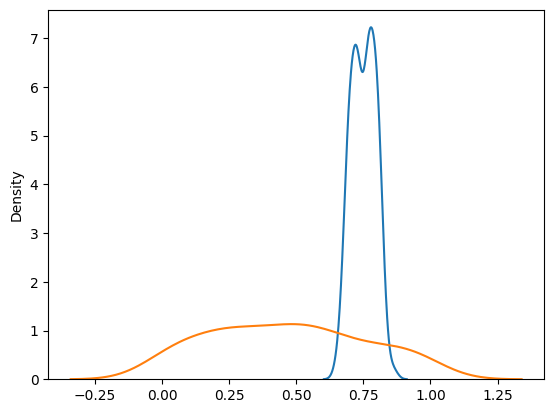

In [19]:
sns.kdeplot(input_dataset[:,0])
sns.kdeplot(rnd_dataset[:,0])

<AxesSubplot: ylabel='Density'>

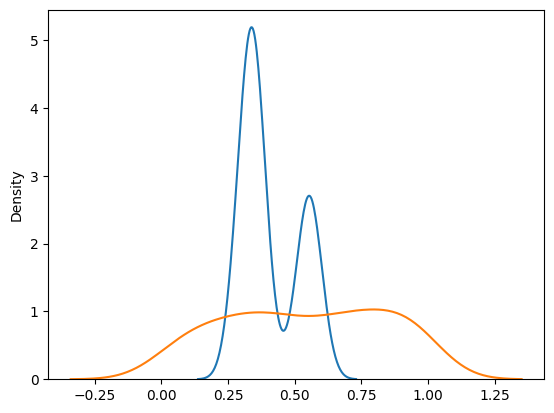

In [23]:
sns.kdeplot(input_dataset[:,1])
sns.kdeplot(rnd_dataset[:,1])

<AxesSubplot: ylabel='Density'>

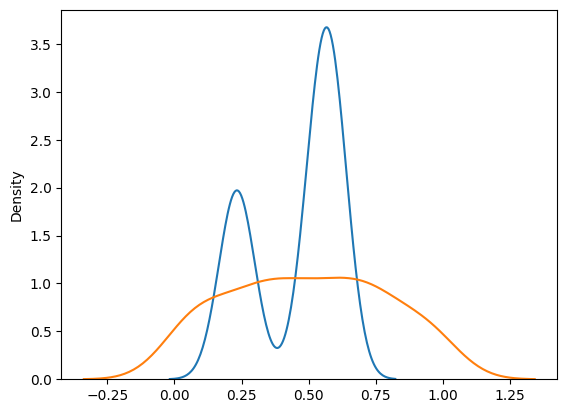

In [24]:
sns.kdeplot(input_dataset[:,2])
sns.kdeplot(rnd_dataset[:,2])

<AxesSubplot: ylabel='Density'>

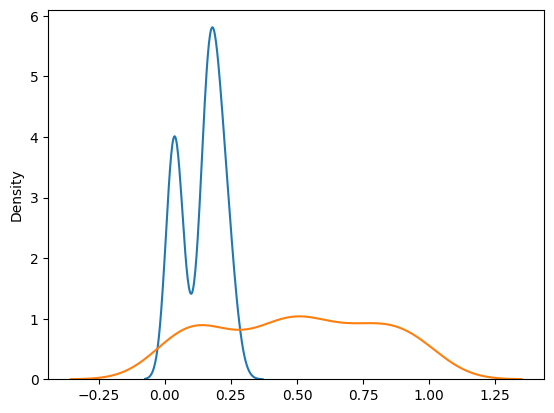

In [22]:
sns.kdeplot(input_dataset[:,3])
sns.kdeplot(rnd_dataset[:,3])